Election de 2022 premier tour

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import os
os.listdir()

['migrations',
 'election2017.ipynb',
 '.DS_Store',
 'populations',
 'securite',
 'alembic.ini',
 'enums',
 'utils',
 'models',
 'election2012.ipynb',
 'exports',
 'labo1.ipynb',
 '.gitignore',
 'population.ipynb',
 'scripts',
 'db',
 'securite.ipynb',
 'chomages',
 'labo2.ipynb',
 '.git',
 'main.py',
 'election2022.ipynb',
 'elections']

#### Importer la database

In [ ]:
from db import SessionLocal
from models import Departement

session = SessionLocal()



Import des datasets.

In [2]:
df = pd.read_excel('./elections/presidentielles-2022-1.xlsx')

Visualise toutes les colones

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

df.head()

,Code du département,Libellé du département,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot,Sexe,Nom,Prénom,Voix,% Voix/Ins,% Voix/Exp,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,01,Ain,Complet,438109,97541,22.26,340568,77.74,5641,1.29,1.66,1903,0.43,0.56,333024,76.01,97.78,F,ARTHAUD,Nathalie,1658,0.38,0.50,M,ROUSSEL,Fabien,5938,1.36,1.78,M,MACRON,Emmanuel,92206,21.05,27.69,M,LASSALLE,Jean,10876,2.48,3.27,F,LE PEN,Marine,86755,19.80,26.05,M,ZEMMOUR,Éric,27530,6.28,8.27,M,MÉLENCHON,Jean-Luc,57832,13.20,17.37,F,HIDALGO,Anne,5644,1.29,1.69,M,JADOT,Yannick,15843,3.62,4.76,F,PÉCRESSE,Valérie,17572,4.01,5.28,M,POUTOU,Philippe,2172,0.50,0.65,M,DUPONT-AIGNAN,Nicolas,8998,2.05,2.70
1,02,Aisne,Complet,373544,101089,27.06,272455,72.94,3767,1.01,1.38,2828,0.76,1.04,265860,71.17,97.58,F,ARTHAUD,Nathalie,2038,0.55,0.77,M,ROUSSEL,Fabien,5968,1.60,2.24,M,MACRON,Emmanuel,58721,15.72,22.09,M,LASSALLE,Jean,6468,1.73,2.43,F,LE PEN,Marine,104342,27.93,39.25,M,ZEMMOUR,Éric,18266,4.89,6.87,M,MÉLENCHON,Jean-Luc,41172,11.02,15.49,F,HIDALGO,Anne,2983,0.80,1.12,M,JADOT,Yannick,7074,1.89,2.66,F,PÉCRESSE,Valérie,10920,2.92,4.11,M,POUTOU,Philippe,2118,0.57,0.80,M,DUPONT-AIGNAN,Nicolas,5790,1.55,2.18
2,03,Allier,Complet,249991,58497,23.40,191494,76.60,3749,1.50,1.96,1790,0.72,0.93,185955,74.38,97.11,F,ARTHAUD,Nathalie,1359,0.54,0.73,M,ROUSSEL,Fabien,8119,3.25,4.37,M,MACRON,Emmanuel,49706,19.88,26.73,M,LASSALLE,Jean,7782,3.11,4.18,F,LE PEN,Marine,50315,20.13,27.06,M,ZEMMOUR,Éric,12361,4.94,6.65,M,MÉLENCHON,Jean-Luc,31013,12.41,16.68,F,HIDALGO,Anne,3280,1.31,1.76,M,JADOT,Yannick,5982,2.39,3.22,F,PÉCRESSE,Valérie,10319,4.13,5.55,M,POUTOU,Philippe,1503,0.60,0.81,M,DUPONT-AIGNAN,Nicolas,4216,1.69,2.27
3,04,Alpes-de-Haute-Provence,Complet,128075,29290,22.87,98785,77.13,1478,1.15,1.50,624,0.49,0.63,96683,75.49,97.87,F,ARTHAUD,Nathalie,505,0.39,0.52,M,ROUSSEL,Fabien,2721,2.12,2.81,M,MACRON,Emmanuel,20800,16.24,21.51,M,LASSALLE,Jean,4309,3.36,4.46,F,LE PEN,Marine,26010,20.31,26.90,M,ZEMMOUR,Éric,7926,6.19,8.20,M,MÉLENCHON,Jean-Luc,21856,17.07,22.61,F,HIDALGO,Anne,1396,1.09,1.44,M,JADOT,Yannick,3957,3.09,4.09,F,PÉCRESSE,Valérie,3834,2.99,3.97,M,POUTOU,Philippe,865,0.68,0.89,M,DUPONT-AIGNAN,Nicolas,2504,1.96,2.59
4,05,Hautes-Alpes,Complet,113519,25357,22.34,88162,77.66,1395,1.23,1.58,532,0.47,0.60,86235,75.97,97.81,F,ARTHAUD,Nathalie,428,0.38,0.50,M,ROUSSEL,Fabien,1925,1.70,2.23,M,MACRON,Emmanuel,20507,18.06,23.78,M,LASSALLE,Jean,3871,3.41,4.49,F,LE PEN,Marine,19696,17.35,22.84,M,ZEMMOUR,Éric,6164,5.43,7.15,M,MÉLENCHON,Jean-Luc,19718,17.37,22.87,F,HIDALGO,Anne,1459,1.29,1.69,M,JADOT,Yannick,5013,4.42,5.81,F,PÉCRESSE,Valérie,4511,3.97,5.23,M,POUTOU,Philippe,801,0.71,0.93,M,DUPONT-AIGNAN,Nicolas,2142,1.89,2.48


In [4]:
df.shape

(107, 89)

Recuperer les information généraux sur les élections départemental

In [8]:
df_infos_general = df.iloc[:, :17]
df_infos_general.head()

,Code du département,Libellé du département,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot
0,01,Ain,Complet,438109,97541,22.26,340568,77.74,5641,1.29,1.66,1903,0.43,0.56,333024,76.01,97.78
1,02,Aisne,Complet,373544,101089,27.06,272455,72.94,3767,1.01,1.38,2828,0.76,1.04,265860,71.17,97.58
2,03,Allier,Complet,249991,58497,23.40,191494,76.60,3749,1.50,1.96,1790,0.72,0.93,185955,74.38,97.11
3,04,Alpes-de-Haute-Provence,Complet,128075,29290,22.87,98785,77.13,1478,1.15,1.50,624,0.49,0.63,96683,75.49,97.87
4,05,Hautes-Alpes,Complet,113519,25357,22.34,88162,77.66,1395,1.23,1.58,532,0.47,0.60,86235,75.97,97.81


Renommer les colonnes des information généraux sur les élections départemental

In [9]:
df_infos_general.columns = [
    "code_dept", "nom_dept", "etat_saisie", "nb_inscrits", "nb_abstentions",
    "pct_abstentions", "nb_votants", "pct_votants", "nb_blancs",
    "pct_blancs_inscrits", "pct_blancs_votants", "nb_nuls",
    "pct_nuls_inscrits", "pct_nuls_votants", "nb_exprimes",
    "pct_exprimes_inscrits", "pct_exprimes_votants"
]
df_infos_general.head()

,code_dept,nom_dept,etat_saisie,nb_inscrits,nb_abstentions,pct_abstentions,nb_votants,pct_votants,nb_blancs,pct_blancs_inscrits,pct_blancs_votants,nb_nuls,pct_nuls_inscrits,pct_nuls_votants,nb_exprimes,pct_exprimes_inscrits,pct_exprimes_votants
0,01,Ain,Complet,438109,97541,22.26,340568,77.74,5641,1.29,1.66,1903,0.43,0.56,333024,76.01,97.78
1,02,Aisne,Complet,373544,101089,27.06,272455,72.94,3767,1.01,1.38,2828,0.76,1.04,265860,71.17,97.58
2,03,Allier,Complet,249991,58497,23.40,191494,76.60,3749,1.50,1.96,1790,0.72,0.93,185955,74.38,97.11
3,04,Alpes-de-Haute-Provence,Complet,128075,29290,22.87,98785,77.13,1478,1.15,1.50,624,0.49,0.63,96683,75.49,97.87
4,05,Hautes-Alpes,Complet,113519,25357,22.34,88162,77.66,1395,1.23,1.58,532,0.47,0.60,86235,75.97,97.81


## Analyse exploratoire des données

Elle sert à vérifier que les données sont complètes et cohérentes, à identifier ce qui est réellement informatif (variables utiles) et ce qui est redondant ou inutile, à détecter d’éventuelles anomalies ou valeurs aberrantes, et à appréhender la structure globale des données (volumes, proportions, variabilité entre départements).

#### Structure globale du DataFrame

Permet de repérer les colonnes vides, les types incorrects, et d’avoir une première idée de la taille du jeu de données.

In [10]:
df_infos_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_dept              107 non-null    object 
 1   nom_dept               107 non-null    object 
 2   etat_saisie            107 non-null    object 
 3   nb_inscrits            107 non-null    int64  
 4   nb_abstentions         107 non-null    int64  
 5   pct_abstentions        107 non-null    float64
 6   nb_votants             107 non-null    int64  
 7   pct_votants            107 non-null    float64
 8   nb_blancs              107 non-null    int64  
 9   pct_blancs_inscrits    107 non-null    float64
 10  pct_blancs_votants     107 non-null    float64
 11  nb_nuls                107 non-null    int64  
 12  pct_nuls_inscrits      107 non-null    float64
 13  pct_nuls_votants       107 non-null    float64
 14  nb_exprimes            107 non-null    int64  
 15  pct_ex

#### Analyser les valeurs manquantes

Analyser les valeurs manquantes est essentiel car leur présence peut fausser l’analyse statistique et les modèles de prédiction : une valeur absente peut modifier les moyennes, les pourcentages ou les corrélations, introduire des biais et provoquer des erreurs ou de mauvaises performances lors de l’entraînement des modèles de machine learning.

In [11]:
df_infos_general.isnull().sum()

code_dept                0
nom_dept                 0
etat_saisie              0
nb_inscrits              0
nb_abstentions           0
pct_abstentions          0
nb_votants               0
pct_votants              0
nb_blancs                0
pct_blancs_inscrits      0
pct_blancs_votants       0
nb_nuls                  0
pct_nuls_inscrits        0
pct_nuls_votants         0
nb_exprimes              0
pct_exprimes_inscrits    0
pct_exprimes_votants     0
dtype: int64

#### Analyse descriptive statistique sur les colonnes numériques

Permet de comprendre la distribution, détecter outliers, différences de taille entre départements, etc.

Colonnes numériques pour analyse

In [12]:
colonnes_numeriques = df_infos_general.select_dtypes(include=["int64", "float64"]).columns
df_num = df_infos_general[colonnes_numeriques]

print(df_num.describe())

        nb_inscrits  nb_abstentions  pct_abstentions    nb_votants  \
count  1.070000e+02      107.000000       107.000000  1.070000e+02   
mean   4.555876e+05   119852.046729        27.164579  3.357356e+05   
std    3.510038e+05   117017.797771        11.180297  2.583938e+05   
min    5.045000e+03     2272.000000        19.190000  2.773000e+03   
25%    1.980675e+05    51659.500000        21.780000  1.425685e+05   
50%    3.668590e+05    95369.000000        23.730000  2.743720e+05   
75%    5.991175e+05   158148.500000        25.830000  4.443390e+05   
max    1.813906e+06   931455.000000        69.130000  1.299873e+06   

       pct_votants     nb_blancs  pct_blancs_inscrits  pct_blancs_votants  \
count   107.000000    107.000000           107.000000          107.000000   
mean     72.835421   5080.457944             1.163084            1.614486   
std      11.180297   3492.523741             0.223461            0.320702   
min      30.870000     27.000000             0.220000        

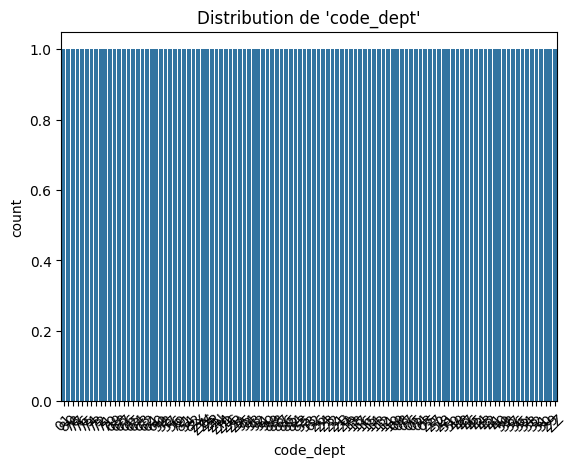

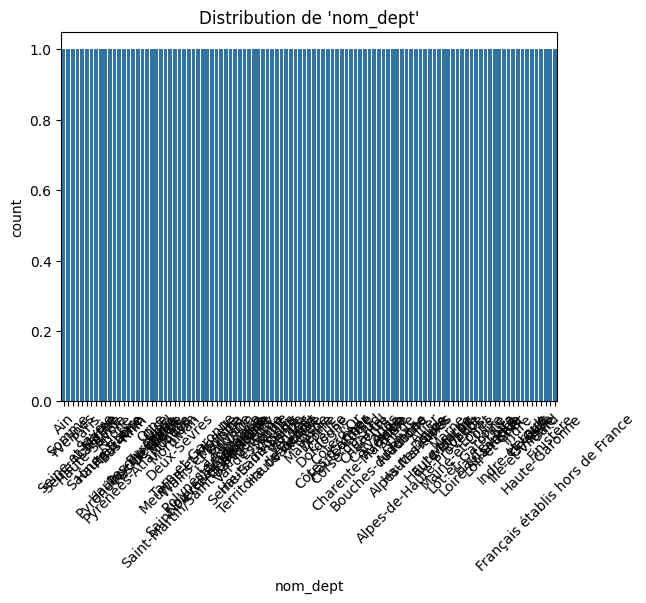

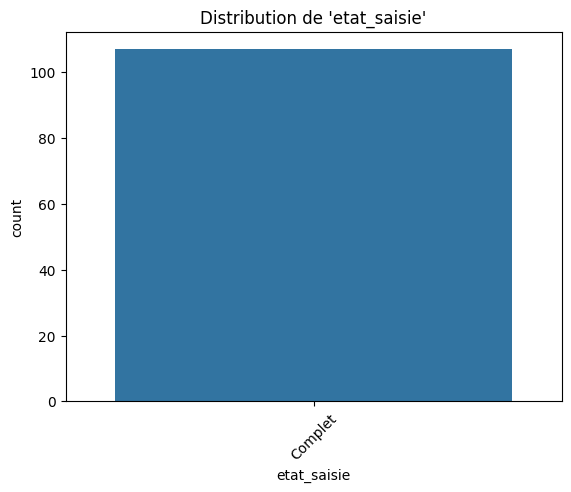

In [13]:
# 5a. Catégorielles restantes (ici code_dept)
for col in df_infos_general.select_dtypes(include=["object"]).columns:
    counts = df_infos_general[col].value_counts()
    sns.countplot(data=df_infos_general, x=col, order=counts.index)
    plt.title(f"Distribution de '{col}'")
    plt.xticks(rotation=45)
    plt.show()

#### Analyse descriptive des variables 

Permet de détecter les colonnes constantes ou redondantes

In [14]:
df_infos_general.describe(include=["object"])

,code_dept,nom_dept,etat_saisie
count,107,107,107
unique,107,107,1
top,01,Ain,Complet
freq,1,1,107


In [ ]:
# 5b. Numériques
for col in df_num.columns:
    sns.histplot(df_num[col], bins=10, kde=True)
    plt.title(f"Distribution de '{col}'")
    plt.show()

Recuperer que les ligne qui ont un état Complet

In [15]:
df_infos_general = df_infos_general[df_infos_general["etat_saisie"] == "Complet"]

<Axes: >

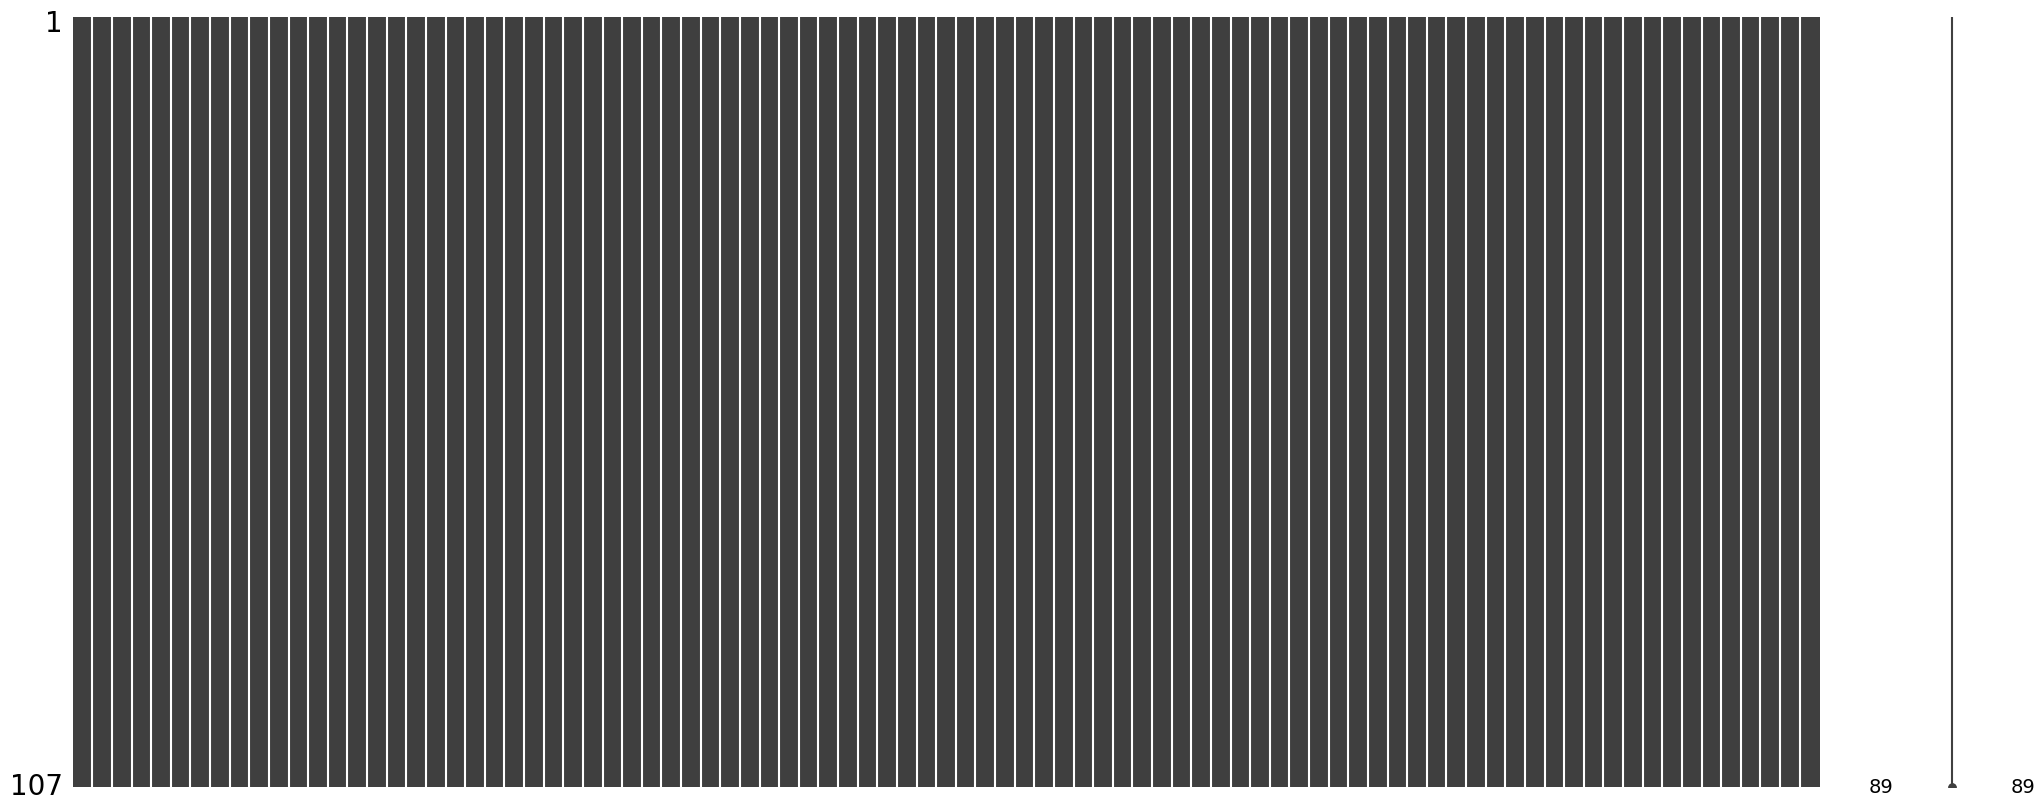

In [16]:
msno.matrix(df)


Visualiser les valeurs manquantes

#### Analyser la distribution

Analyser la distribution des données permet de comprendre comment les valeurs se répartissent (concentration, dispersion, asymétrie) et de détecter d’éventuelles anomalies comme des valeurs aberrantes ou incohérentes.

Analyser les valeurs aberrantes

Analyse les boxes splots

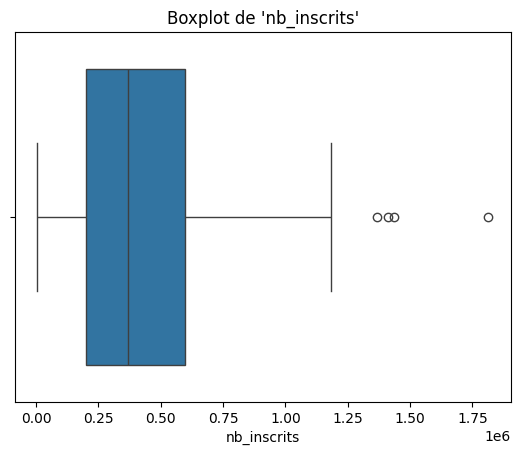

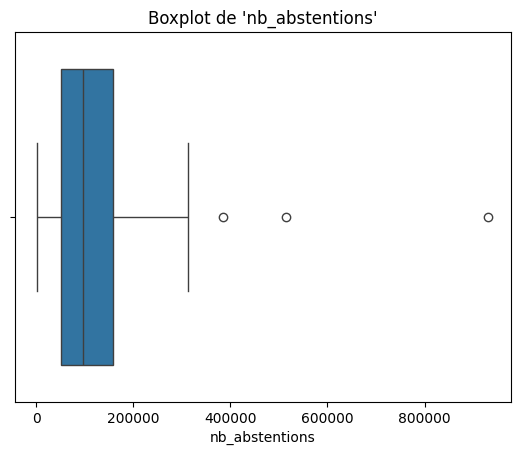

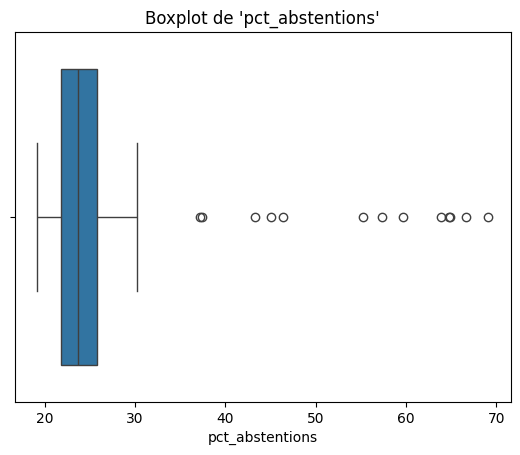

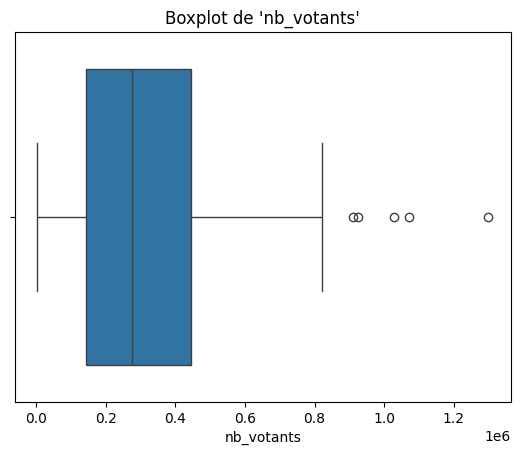

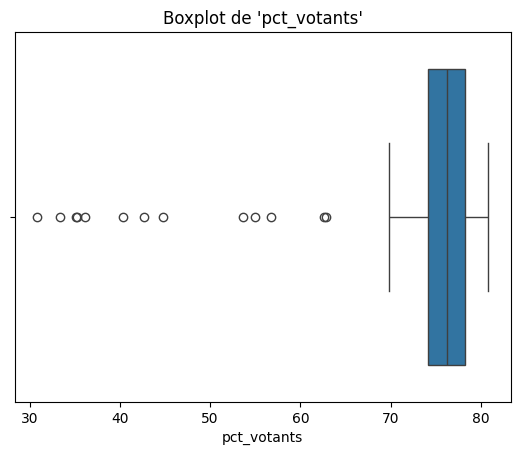

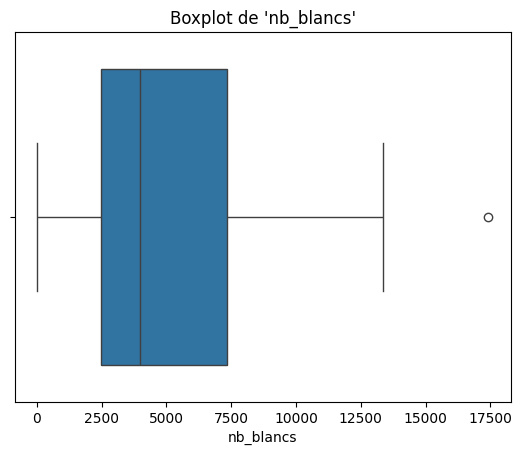

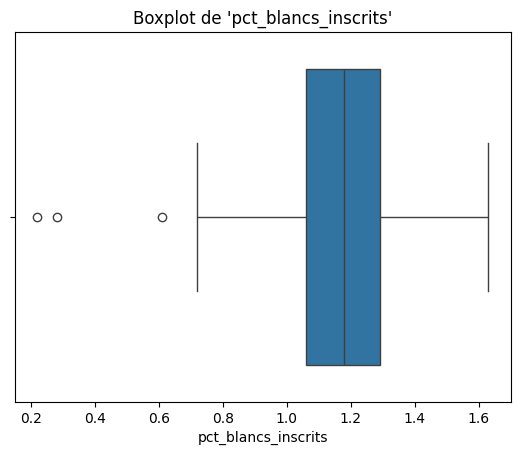

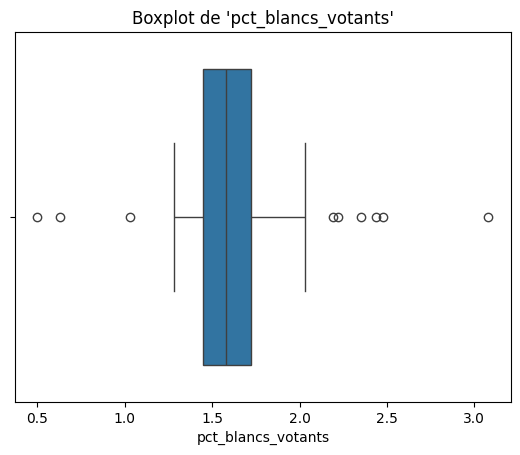

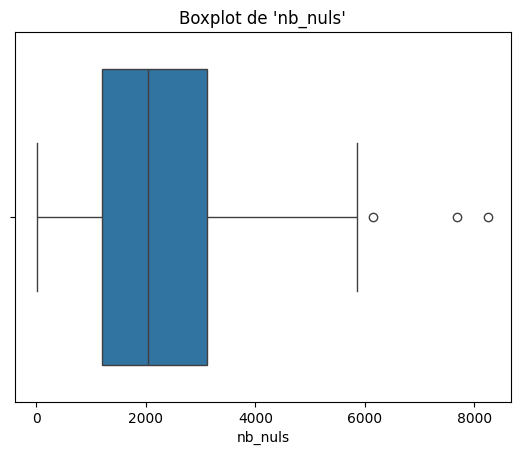

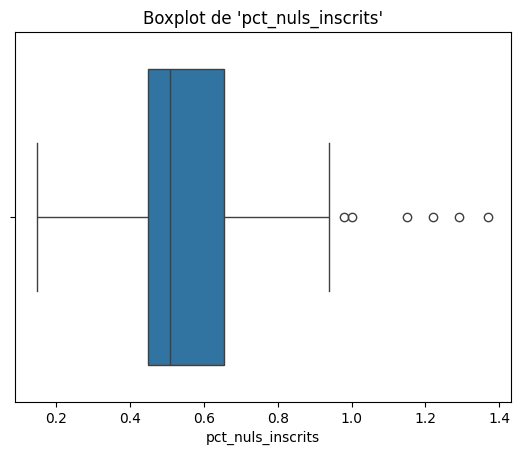

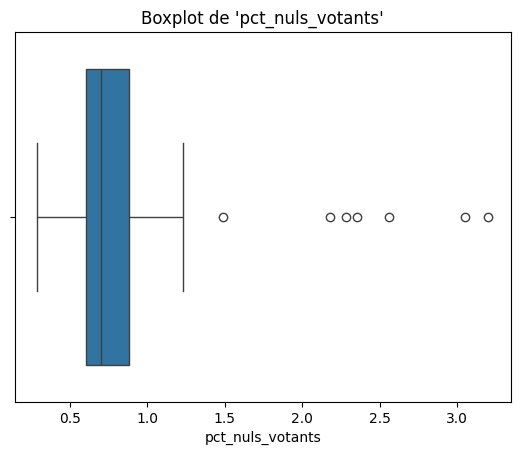

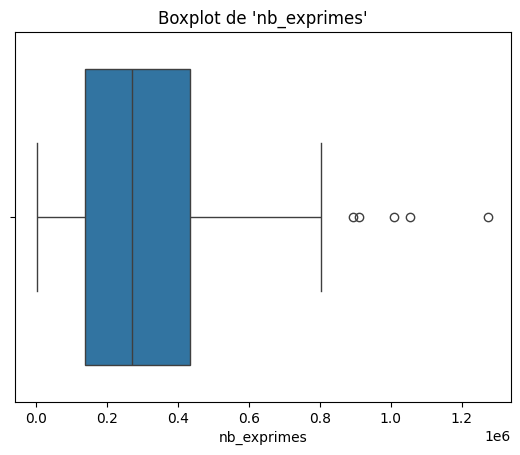

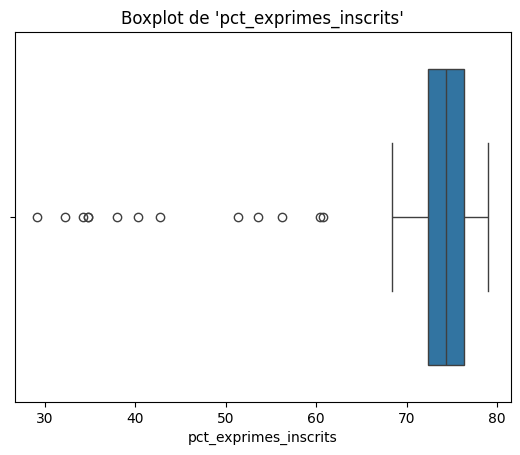

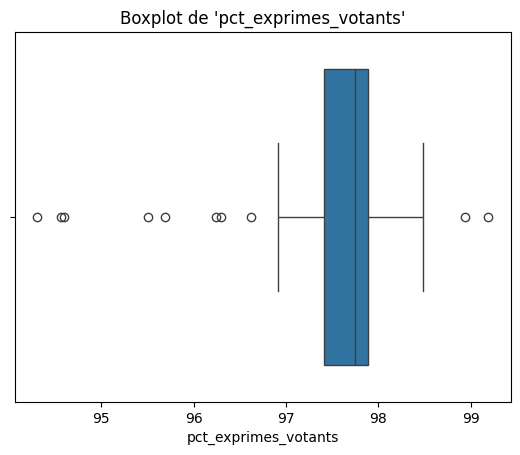

In [17]:
# 6️⃣ Boxplots pour détection des valeurs aberrantes
for col in df_num.columns:
    sns.boxplot(x=df_num[col])
    plt.title(f"Boxplot de '{col}'")
    plt.show()


Matrice de corrélation pour metre en evidance la muticolinéarité entre les variables numériques et un VIF pour mesure à quel point la variance d’un coefficient de régression est augmentée parce qu’une variable explicative est corrélée aux autres.

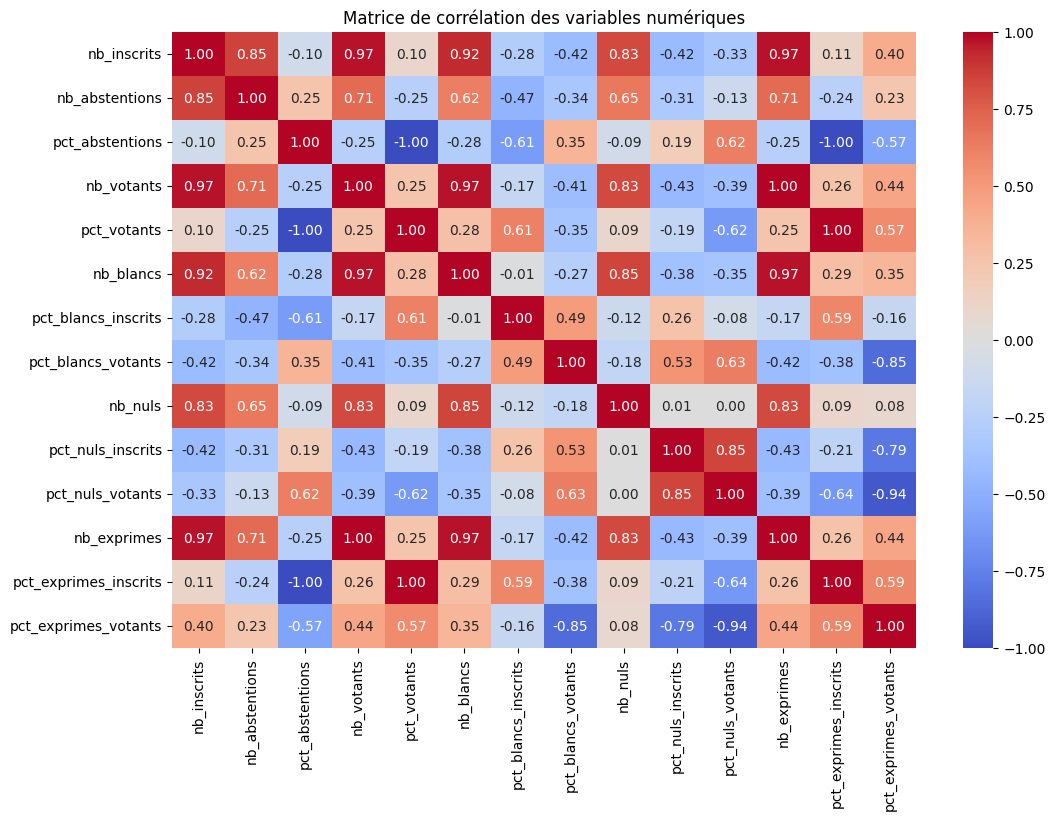

In [18]:
# =========================
# 1️⃣ Matrice de corrélation
# =========================
corr_matrix = df_num.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.show()


In [19]:
# =========================
# 2️⃣ VIF (Variance Inflation Factor)
# =========================

# Ajouter une constante pour le calcul du VIF
X = add_constant(df_num)

vif_data = pd.DataFrame()
vif_data["variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF des variables numériques :")
print(vif_data)

VIF des variables numériques :
                 variable           VIF
0                   const  0.000000e+00
1             nb_inscrits           inf
2          nb_abstentions           inf
3         pct_abstentions           inf
4              nb_votants           inf
5             pct_votants           inf
6               nb_blancs           inf
7     pct_blancs_inscrits  1.437722e+03
8      pct_blancs_votants  4.099844e+03
9                 nb_nuls           inf
10      pct_nuls_inscrits  1.264912e+03
11       pct_nuls_votants  9.534491e+03
12            nb_exprimes           inf
13  pct_exprimes_inscrits  3.630907e+06
14   pct_exprimes_votants  2.130644e+04


/usr/local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Suppression des données redondantes, risque de multicolinéarité en ML

,code_dept,nom_dept,nb_inscrits,nb_abstentions,nb_votants,nb_blancs,nb_nuls
0,01,Ain,438109,97541,340568,5641,1903
1,02,Aisne,373544,101089,272455,3767,2828
2,03,Allier,249991,58497,191494,3749,1790
3,04,Alpes-de-Haute-Provence,128075,29290,98785,1478,624
4,05,Hautes-Alpes,113519,25357,88162,1395,532


In [22]:
df_infos_general_base.shape

(107, 7)

In [23]:
df_departement = df_infos_general_base.iloc[:, :2]
df_departement.head()

,code_dept,nom_dept
0,01,Ain
1,02,Aisne
2,03,Allier
3,04,Alpes-de-Haute-Provence
4,05,Hautes-Alpes


In [24]:
df_stat_elections = df_infos_general_base.drop(columns=["nom_dept"])
df_stat_elections.head()

,code_dept,nb_inscrits,nb_abstentions,nb_votants,nb_blancs,nb_nuls
0,01,438109,97541,340568,5641,1903
1,02,373544,101089,272455,3767,2828
2,03,249991,58497,191494,3749,1790
3,04,128075,29290,98785,1478,624
4,05,113519,25357,88162,1395,532


### Le test de ki2 pour verifier le lien entre deux variables qualitatif
### Le V2Cramer ou tupro pour mesurer l'intancite du lien

Entre deux varialbles quantitatif il faut faire des boxplot bivarier pour mesurer leurs relations

Test non parametrique entre une variable quantitatif et une variable quantitatif: krukal wallis

Infos sur les departements

Infos résultat des candidats par départements

### Partion

Partion de la base de donnée, tel que la base d'aprentissage = 0,7 et la base de test = 0,3

Tratification pour consever les proportions

In [ ]:
print(df)

In [ ]:
import pandas as pd

# Colonnes globales que l'on veut garder
cols_globales = ['Code du département', 'Libellé du département']

# Colonnes répétitives candidats
df_candidates = df.iloc[:, 17:]  # après % Exp/Vot
cols_per_candidate = 6
num_candidates = df_candidates.shape[1] // cols_per_candidate

dfs_list = []

for i in range(num_candidates):
    start_col = i * cols_per_candidate
    end_col = start_col + cols_per_candidate
    df_cand = df_candidates.iloc[:, start_col:end_col].copy()
    df_cand.columns = ['Sexe', 'Nom', 'Prenom', 'Voix', '% Voix/Ins', '% Voix/Exp']
    
    # Ajouter les informations de département
    df_cand = pd.concat([df[cols_globales], df_cand], axis=1)
    
    dfs_list.append(df_cand)

# Combiner tous les candidats
df_simple = pd.concat(dfs_list, ignore_index=True)

# Colonnes à garder
cols_to_keep = ['Code du département', 'Libellé du département', 'Sexe', 'Nom', 'Prenom', 'Voix']

# Nouveau dataframe simplifié
df_candidat_resultat = df_simple[cols_to_keep]

# Afficher toutes les lignes
pd.set_option('display.max_rows', 10)  # ou un nombre supérieur à 100
pd.set_option('display.max_columns', None)  # pour voir toutes les colonnes
pd.set_option('display.width', None)        # pour éviter la coupure à la largeur de l'écran


# Affichage des 5 premières lignes
df_candidat_resultat.head(1000)


In [ ]:
from utils.election_importer import ElectionImporter
from datetime import date
from enums.sexe import SexeEnum
from enums.type_election import TypeElection

# Instanciation
importer = ElectionImporter()

# Import des départements
importer.import_departements(df_departement)

# Créer ou récupérer l’élection
election = importer.get_or_create_election(date(2022, 4, 10), TypeElection.PRESIDENTIELLE)

# Import des stats
importer.import_stats(df_stat_elections, election.id)

# Import des candidats et résultats
importer.import_candidats_resultats(df_candidat_resultat, election.id)


In [ ]:
from utils.election_dataframe import ElectionDataFrame

edf = ElectionDataFrame("./elections/presidentielles-2022-2.xlsx")

In [ ]:
# Liste des candidats
edf.get_candidats()

In [ ]:
# Voix de Mélenchon par département
edf.get_voix_par_departement("LE PEN", "Marine")

In [ ]:
# Stats du département 59
edf.get_stats_departement("59")

In [ ]:
# Stats + voix pour Macron dans le 75
edf.get_stats_departement_candidat("59", "LE PEN", "Marine")

In [ ]:
df_departement = edf.df_departement
print(df_departement.head())

In [ ]:
df_stat_elections = edf.df_stat_elections
print(df_stat_elections.head())

In [ ]:
df_candidat_resultat = edf.df_candidat_resultat
print(df_candidat_resultat.head())